In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set()

# Prepare Data

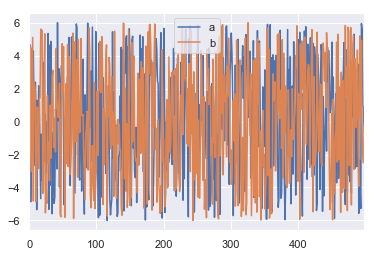

In [2]:
size_d = 500 # sample size
var_dim = 2  # dimension of variable.
var_name_list = ['a', 'b']

x = np.array([list(np.random.permutation(np.linspace(-6, 6, size_d))) for _ in range(var_dim)]).T

df_x = pd.DataFrame(data=x, columns=var_name_list)
df_x.plot()
plt.show()

## Define observation process.
We use a simple process because inverse kernel regressin looks like not be able to handle difficult process.

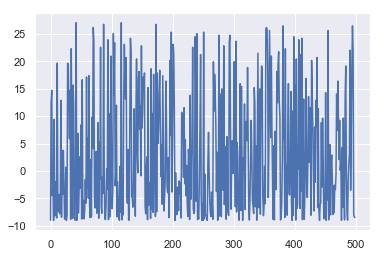

In [3]:
def obs_process(x):
    return (x[0]-3)*(x[0]+3)
#     return (5*(x+3)*x*(x-3)).sum()
y_true = np.array([obs_process(_) for _ in df_x.values])
sns.lineplot(x=range(len(y_true)), y=y_true)

In [4]:
# Prepare test data.
np.random.seed(0)
y_noise = y_true + np.random.randn(size_d) * 1.0
size_p = 100
new_x_idx = np.random.permutation(df_x.index)
new_x_idx = new_x_idx[:size_p]
new_x_idx.sort()
df_new_x = df_x.loc[new_x_idx, :]
new_x = df_new_x.values
new_y_true = np.array([obs_process(_) for _ in df_new_x.values])

In [5]:
df_x.loc[:, 'y_true'] = y_true
df_x.loc[:, 'y_noise'] = y_noise
df_x['Predict_objective'] = np.nan
for i, idx in enumerate(new_x_idx):
    df_x.loc[idx, 'Predict_objective'] = new_y_true[i]

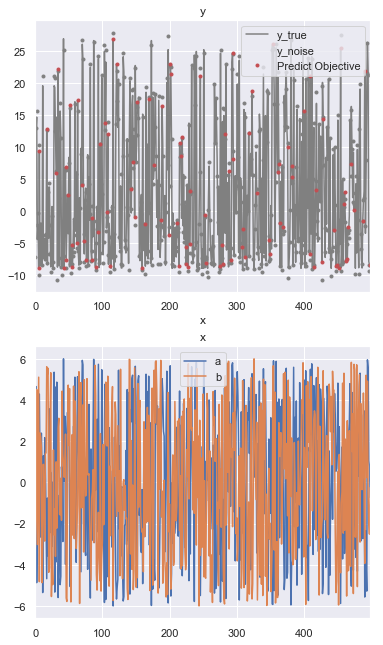

In [6]:
fig, ax = plt.subplots(2,1, figsize=(6,11))
df_x.loc[:,var_name_list].plot(ax=ax[1])
pd.DataFrame(
    {'x': df_x.index,
     'y_true': y_true}).plot(x='x', ax=ax[0], style='-', color='gray')
pd.DataFrame(
    {'x': df_x.index,
     'y_noise': y_noise}).plot(x='x', ax=ax[0], style='.', color='gray')
pd.DataFrame(
    {'x': df_new_x.index,
     'Predict Objective': new_y_true}).plot(x='x', ax=ax[0], style='.', color='r')
ax[0].set_title('y')
ax[1].set_title('x')
plt.show()

## Inverse kernel regression

In [7]:
sample_size = 200  # Size of data to be used in learning.
beta = 1.0  # Kernel parameter
theta = 1.0  # Regularize parameter

# Gaussian Kernel
def kernel(x1, x2, beta=beta):
    return np.exp(- beta * np.linalg.norm(x1 - x2))

# Sampling teacher data.
df = df_x.sample(sample_size)
selected_x = df.loc[:, var_name_list].values
selected_y = df.loc[:, 'y_noise'].values

# Gram matrix.
K = np.zeros((sample_size, sample_size))
for i in range(sample_size):
    for j in range(sample_size):
        K[i,j] = kernel(selected_x[i], selected_x[j])

In [8]:
# Compute Inverse of Yt@K@Y
YtKY = (np.matrix(selected_y))@(np.matrix(K))@(np.matrix(selected_y).T)
YtKYinv = np.linalg.pinv(YtKY + theta*np.identity(YtKY.shape[0]))

# Compute SY
SY = selected_y.T@selected_y

# Weight coefficient of each data point.
C_ = SY*(YtKYinv@(np.matrix(selected_y)))

In [9]:
# Weight of new data of each data point. 
w_x = np.zeros((sample_size, size_p))
for i in range(sample_size):
    for j in range(size_p):
        w_x[i, j] = kernel(new_x[j, :], selected_x[i, :])  

In [10]:
# Predict
y_predict = C_@w_x

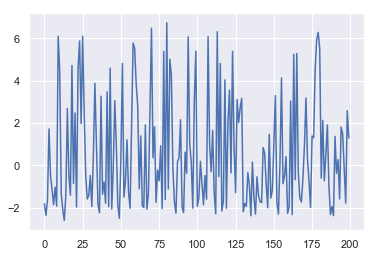

In [11]:
sns.lineplot(x=range(200), y=C_.A.reshape(-1))

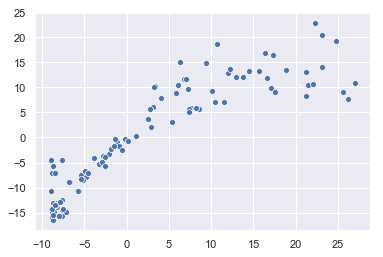

In [12]:
sns.scatterplot(x=new_y_true, y=y_predict.A.reshape(-1))
plt.show()

## Predict Another data

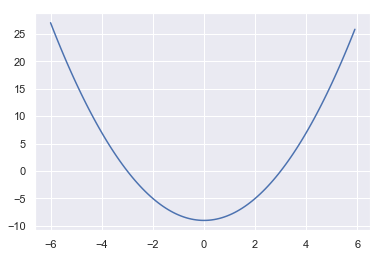

In [13]:
def myx2(x):
    return np.array([x, 0.12783293])
x2 = np.array([myx2(_) for _ in np.arange(-6,6, 0.1)])
y_true2 = np.array([obs_process(_) for _ in x2])
sns.lineplot(x=np.arange(-6,6, 0.1), y=y_true2)
plt.show()

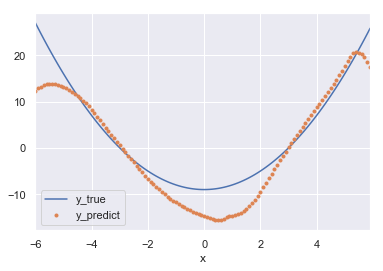

In [14]:
size_p2 = y_true2.shape[0]

# Weight of new data of each data point. 
w_x = np.zeros((sample_size, size_p2))
for i in range(sample_size):
    for j in range(size_p2):
        w_x[i, j] = kernel(x2[j, :], selected_x[i, :])  

# Prediction
y_predict2 = (C_@w_x).A.reshape(-1)

fig, ax = plt.subplots()
pd.DataFrame(
    {'x': [_[0] for _ in x2],
     'y_true': y_true2}).plot(x='x', ax=ax)
pd.DataFrame(
    {'x': [_[0] for _ in x2],
     'y_predict': y_predict2}).plot(x='x', style='.', ax=ax)
plt.show()